Forward-Modelling Spectral Lines
==================

This is the code accompanying XXX Add paper link XXX. The plots and analysis from the paper can be reproduced from this notebook.

We compare several commonly-used methods for estimating the line width of a Gaussian. We also assess whether typically-used correction factors can account for broadening due to the channel width and a spectral response function.

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sb
import numpy as np
from astropy.modeling import models, fitting
from astropy.convolution import convolve_fft
from scipy.special import erf
from scipy.interpolate import InterpolatedUnivariateSpline
from os.path import join as osjoin
from scipy.optimize import curve_fit

from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 11.7, 8.27

import seaborn as sb
sb.set(font='Times New Roman', style='ticks',
       rc={'text.usetex': True})

sb.set_context("poster", font_scale=1.0,
               rc={"figure.figsize": (12, 16)})
sb.set_palette("colorblind")

def twocolumn_figure_paper():
    width = 8.4
    # Keep the default ratio used in seaborn. This can get overwritten.
    height = (4.4 / 6.4) * width
    figsize = (width, height)
    sb.set_context("paper", font_scale=1.25,
                   rc={"figure.figsize": figsize})
    sb.set_palette("colorblind")
    
def onecolumn_figure_paper():
    width = 4.2
    # Keep the default ratio used in seaborn. This can get overwritten.
    height = (4.4 / 6.4) * width
    figsize = (width, height)
    sb.set_context("paper", font_scale=1.25,
                   rc={"figure.figsize": figsize})
    sb.set_palette("colorblind")

Define functions for the different width estimations:

* Gaussian model
* Gaussian sampled over finite channels
* Equivalent Gaussian width ([Heyer et al. 2001](https://ui.adsabs.harvard.edu/#abs/2001ApJ...551..852H/abstract), [Leroy et al. 2016](https://ui.adsabs.harvard.edu/#abs/2016ApJ...831...16L/abstract), [Sun et al. 2018](https://ui.adsabs.harvard.edu/#abs/2018ApJ...860..172S/abstract))
* Second Moment
* Half-width-half-max ([Stilp et al. 2013a](https://ui.adsabs.harvard.edu/#abs/2013ApJ...765..136S/abstract), [Stilp et al. 2013b](https://ui.adsabs.harvard.edu/#abs/2013ApJ...773...88S/abstract), [Koch et al. 2018](https://ui.adsabs.harvard.edu/#abs/2018MNRAS.479.2505K/abstract))

In [16]:
def gauss_model(vels, amp=1., stddev=10., mean=0.):
    '''
    1D Gaussian
    '''
    return models.Gaussian1D(amplitude=amp, stddev=stddev, mean=mean)(vels)


def gauss_weighted_avg(a, b, amp=1., stddev=10., mean=0.):
    '''
    Weighted average of a 1D Gaussian from a to b
    '''

    SQRT2 = np.sqrt(2)

    erf_term = erf((mean - a) / (SQRT2 * stddev)) - \
        erf((mean - b) / (SQRT2 * stddev))

    return (amp * stddev / (b - a)) * erf_term * np.sqrt(np.pi / 2.)


def gauss_model_chanweight(vels, amp=1., stddev=10., mean=0.):
    '''
    1D Gaussian weighted over a set of finite spectral channels.
    '''

    # Assume the channels are equally spaced.
    chan_width = np.abs(np.diff(vels[:2])[0])

    low_vels = vels - chan_width / 2.
    high_vels = vels + chan_width / 2.

    vals = np.zeros_like(vels)

    for i, (low, high) in enumerate(zip(low_vels, high_vels)):
        vals[i] = gauss_weighted_avg(low, high, amp, stddev, mean)

    return vals


# Empirical measures of width


def equiv_gauss_width(integrated, peak):
    '''
    Use the integrated and intensity and peak brightness to estimate
    the line width.
    '''
    return integrated / (np.sqrt(2 * np.pi) * peak)


def moment2_width(vels, spec):
    '''
    Line width from the sqrt of the second moment.
    '''

    cent = np.sum(spec * vels) / np.sum(spec)

    return np.sqrt(np.sum(spec * (vels - cent)**2) / np.sum(spec))


def find_hwhm(vels, spectrum, interp_factor=10):
    '''
    Estimate the line width from the HWHM positions.
    '''

    halfmax = spectrum.max() * 0.5

    # Model the spectrum with a spline
    # x values must be increasing for the spline, so flip if needed.
    spec_for_interp, vels_for_interp = reorder_spectra(vels, spectrum)

    interp1 = InterpolatedUnivariateSpline(vels_for_interp,
                                           spec_for_interp - halfmax, k=3)

    fwhm_points = interp1.roots()
    if len(fwhm_points) < 2:
        raise ValueError("Found less than 2 roots!")
    # Only keep the min/max if there are multiple
    fwhm_points = (min(fwhm_points), max(fwhm_points))

    fwhm = fwhm_points[1] - fwhm_points[0]

    # Convert to equivalent Gaussian sigma
    sigma = fwhm / np.sqrt(8 * np.log(2))

    # Upsample in velocity to estimate the peak position
    interp_factor = float(interp_factor)
    chan_size = np.diff(vels_for_interp[:2])[0] / interp_factor
    upsamp_vels = np.linspace(vels_for_interp.min(),
                              vels_for_interp.max() + 0.9 * chan_size,
                              vels_for_interp.size * interp_factor)
    upsamp_spec = interp1(upsamp_vels)
    peak_velocity = upsamp_vels[np.argmax(upsamp_spec)]

    return sigma, fwhm_points, peak_velocity


def reorder_spectra(vels, spectrum):
    spec_for_interp = spectrum if np.diff(vels[:2])[0] > 0 else spectrum[::-1]
    vels_for_interp = vels if np.diff(vels[:2])[0] > 0 else vels[::-1]

    return spec_for_interp, vels_for_interp


When spectra are marginally resolved ($\Delta v \approx \sigma$), the channel width will broaden the spectra. A correction factor of
$$\sigma_{\rm chan} \approx \frac{\Delta v}{\sqrt{2\pi}},$$
was proposed by [Rosolowsky & Leroy (2006)](https://ui.adsabs.harvard.edu/#abs/2006PASP..118..590R/abstract). This correction factor is the width of a Gaussian with an area equal to the rectangular area of the channel. This correction factor is subtracted in quadrature from the measured line width.

This correction factor assumes that the channels can be treated independently.  Due to the instrumental spectral response function, real spectral-line data cubes will tend to have moderately correlated channels, which further broadens the spectral line. [Leroy et al. (2016)](https://ui.adsabs.harvard.edu/#abs/2016ApJ...831...16L/abstract) calculate the typical channel-to-channel correlations for a set of CO data cubes, using the effective width (see above) to empirically-derive a modified correction factor:
$$\sigma_{\rm chan} \approx \frac{\Delta v}{\sqrt{2\pi}} \left( 1.0 + 1.18k + 10.4 k^2 \right),$$
where $k$ is the channel-to-channel coupling approximating the spectral response function to be a three-element Hanning kernel with $[k, 1-2k, k]$. The channel coupling $k$ is related to the channel correlation with $k \approx 0.0 + 0.47r - 0.23r^2 - 0.16r^3 + 0.43 r^4$. We will use this empirical relation to approximate the effect of the spectral response function on the line width.

In [17]:
def leroy16_deconv(chan_width, r=0.26):
    k = 0.0 + 0.47 * r - 0.23 * r**2 - 0.16 * r**3 + 0.43 * r**4
    return chan_width * (1.0 + 1.18 * k + 10.4 * k**2) / np.sqrt(2 * np.pi)


def hanning_kernel(r=0.26):
    '''
    Correlation to Hanning kernel from Leroy+16
    '''
    k = 0.0 + 0.47 * r - 0.23 * r**2 - 0.16 * r**3 + 0.43 * r**4
    return np.array([k, 1 - 2 * k, k])

A table of channel correlations is given in [Sun et al. (2018)](https://ui.adsabs.harvard.edu/#abs/2018ApJ...860..172S/abstract) for a number of CO spectral-line data cubes of nearby galaxies. For this example, we will use $r=0.26$, the large scale correlation for M33.

We need a model to go along with the Gaussian, sampled with finite channels, convolved with the spectral response function, and functions for fitting these models:

In [18]:
def convolve_gauss_model_chanweight(vels, kernel, amp=1., stddev=10., mean=0.):
    return convolve_fft(gauss_model_chanweight(vels, amp=amp, stddev=stddev,
                                               mean=mean), kernel)


def fit_discrete_model(vels, spec, p0=(1., 10., 0.), sigma=None):
    '''
    Use curve_fit to fit the broadened model.
    '''
    return curve_fit(lambda vels, amp, stddev, mean:
                     gauss_model_chanweight(vels, amp=amp,
                                            stddev=stddev,
                                            mean=mean),
                     vels, spec, p0=p0, sigma=sigma, absolute_sigma=True)


def fit_convolve_model(vels, spec, kernel, p0=(1., 10., 0.), sigma=None):
    '''
    Use curve_fit to fit the broadened model.
    '''
    return curve_fit(lambda vels, amp, stddev, mean:
                     convolve_gauss_model_chanweight(vels, kernel, amp=amp,
                                                     stddev=stddev,
                                                     mean=mean),
                     vels, spec, p0=p0, sigma=sigma, absolute_sigma=True)

`fit_discrete_model` will fit a Gaussian model sampled at the same spectral channels as the data, thereby accounting for broadening from the finite channels in the model. `fit_convolve_model` expands the previous model by including the spectral response function to account for this source of line broadening as well. These are both cases of forward-modelling, where known systematics are included directly in the model to reproduce the observed data.

How do these sources of line broadening affect the shape of the Gaussian model? We plot a noiseless Gaussian below with channels equal to $\sigma$, the standard deviation of the Gaussian, to compare the effects of sampling over finite channel widths and the spectral response function.

/home/eric/anaconda3/lib/python3.6/site-packages/astropy/convolution/convolve.py:672: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bigarray[arrayslices] = array
/home/eric/anaconda3/lib/python3.6/site-packages/astropy/convolution/convolve.py:678: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bigkernel[kernslices] = normalized_kernel
/home/eric/anaconda3/lib/python3.6/site-packages/astropy/convolution/convolve.py:694: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `a

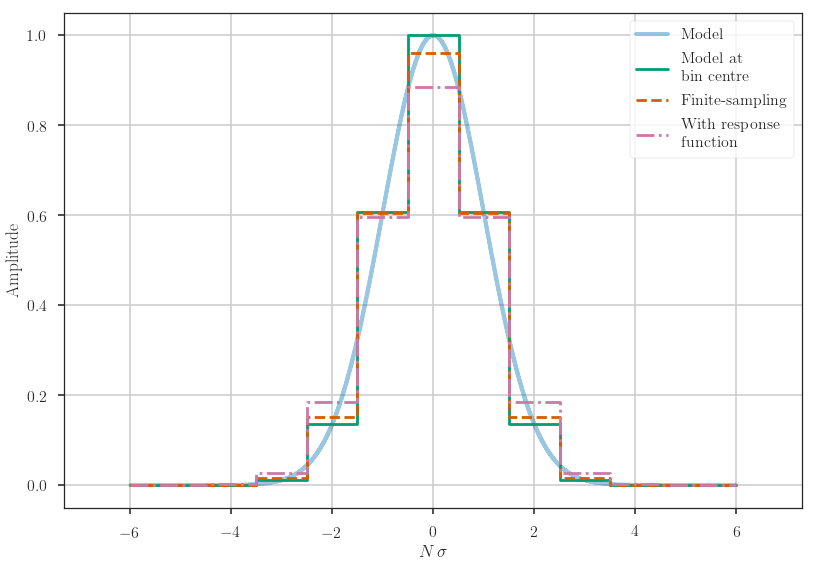

In [19]:
sigma = 10.
r = 0.26

m33_kernel = hanning_kernel(r=r)

vels_5 = np.append(- np.arange(0., 61., 5.)[::-1][:-1], np.arange(0., 61., 5.))
vels_10 = np.append(- np.arange(0., 61., 10.)[::-1][:-1],
                    np.arange(0., 61., 10.))
vels_01 = np.append(- np.arange(0., 60., 0.1)[::-1][:-1],
                    np.arange(0., 60., 0.1))

plt.plot(vels_01 / sigma, gauss_model(vels_01), label='Model',
         drawstyle='steps-mid', linewidth=4, alpha=0.4)
plt.plot(vels_10 / sigma, gauss_model(vels_10), label='Model at \nbin centre',
         drawstyle='steps-mid')
plt.plot(vels_10 / sigma, gauss_model_chanweight(vels_10), '--',
         label='Finite-sampling', drawstyle='steps-mid')
plt.plot(vels_10 / sigma, convolve_gauss_model_chanweight(vels_10, m33_kernel),
         '-.', label='With response \nfunction', drawstyle='steps-mid')
plt.legend(frameon=True, loc='upper right')
plt.grid()
plt.xlim([-7.3, 7.3])
plt.ylabel("Amplitude")
plt.xlabel(r"$N \, \sigma$")
plt.tight_layout()

# plt.savefig("example_model_chan_1sigma.pdf")

The thick blue line is the true shape of the Gaussian, the green solid line shows the shape if the bin centres directly sample the true model, the orange dashed-line is the Gaussian averaged over the channel width, and the pink dot-dashed line is the previous model convolved with a spectral-response function.

The latter two models are moderately broadened compared to the true model. The averaging will also lead to the amplitude being underestimated by at most $\sim10\%$.

However, this model is an ideal case where the peak is located at the centre of a spectral channel. What does the profile look like in the worst case of having a peak located at the edge of channel?

/home/eric/anaconda3/lib/python3.6/site-packages/astropy/convolution/convolve.py:672: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bigarray[arrayslices] = array
/home/eric/anaconda3/lib/python3.6/site-packages/astropy/convolution/convolve.py:678: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bigkernel[kernslices] = normalized_kernel
/home/eric/anaconda3/lib/python3.6/site-packages/astropy/convolution/convolve.py:694: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `a

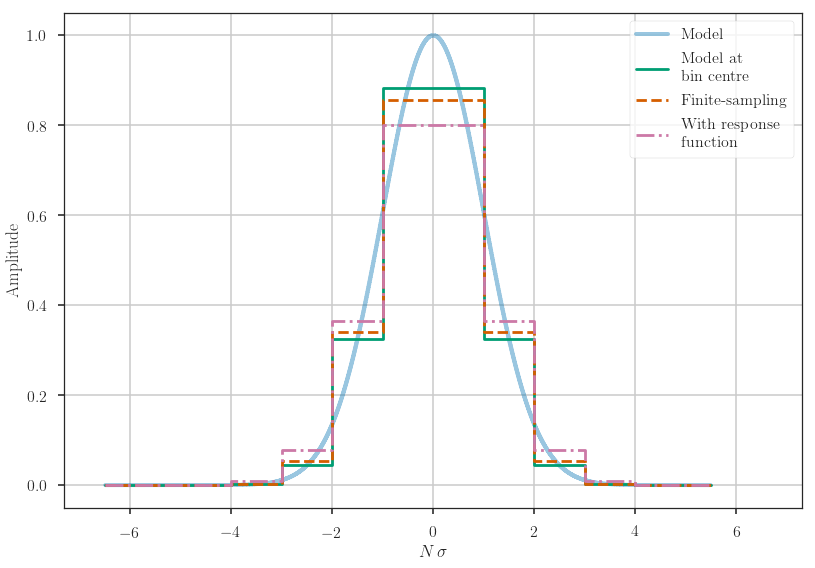

In [20]:
plt.plot((vels_01 - 5.) / sigma, gauss_model(vels_01 - 5.), label='Model',
         drawstyle='steps-mid', linewidth=4, alpha=0.4)
plt.plot((vels_10 - 5.) / sigma, gauss_model(vels_10 - 5.),
         label='Model at \nbin centre',
         drawstyle='steps-mid')
plt.plot((vels_10 - 5.) / sigma, gauss_model_chanweight(vels_10 - 5.), '--',
         label='Finite-sampling', drawstyle='steps-mid')
plt.plot((vels_10 - 5.) / sigma,
         convolve_gauss_model_chanweight(vels_10 - 5., m33_kernel),
         '-.', label='With response \nfunction', drawstyle='steps-mid')
plt.legend(frameon=True, loc='upper right')
plt.grid()
plt.xlim([-7.3, 7.3])
plt.ylabel("Amplitude")
plt.xlabel(r"$N \, \sigma$")
plt.tight_layout()

# plt.savefig("example_model_chan_1sigma_chanoffset.pdf")

The amplitude is underestimated by $\sim20\%$ and the line width, visually, appears to be larger than the prevous case.

These examples are fairly severe cases with spectra marginally Nyquist-sampled. To compare the line width broadening, we will run each line width estimate, with and without a correction factor, to a range of channel widths. First, the best case of having the peak centered on a spectral channel:

In [21]:
chan_widths = np.array([0.1, 0.2, 0.5, 1., 2.5, 5., 10., 15., 20., 30.])

amp = 1.
stddev = 10.
mean = 0.

init_mod = models.Gaussian1D(amplitude=amp, stddev=stddev, mean=mean)

stddev_actual = []
stddev_weight = []
stddev_weight_deconv = []
stddev_weight_formod = []
stddev_weight_equiv = []
stddev_weight_equiv_deconv = []
stddev_weight_mom2 = []
stddev_weight_mom2_deconv = []
stddev_weight_hwhm = []
stddev_weight_hwhm_deconv = []

stddev_weight_resp = []
stddev_weight_resp_formod = []
stddev_weight_resp_deconv = []
stddev_weight_resp_equiv = []
stddev_weight_resp_equiv_deconv = []
stddev_weight_resp_mom2 = []
stddev_weight_resp_mom2_deconv = []
stddev_weight_resp_hwhm = []
stddev_weight_resp_hwhm_deconv = []

for width in chan_widths:

    # Best case: The centre is falls at the middle of a channel
    vels = np.append(- np.arange(0., 60. + width / 2., width)[::-1][:-1],
                     np.arange(0., 60. + width / 2., width))

    gauss_spec = gauss_model(vels)
    gauss_weight_spec = gauss_model_chanweight(vels)

    fitter = fitting.LevMarLSQFitter()

    gauss_fit = fitter(init_mod, vels, gauss_spec)
    stddev_actual.append(gauss_fit.stddev)

    gauss_weight_fit = fitter(init_mod, vels, gauss_weight_spec)
    stddev_weight.append(gauss_weight_fit.stddev)

    stddev_weight_deconv.append(np.sqrt(gauss_weight_fit.stddev**2 -
                                        leroy16_deconv(width, r=0.)**2))

    # Correct fit
    gauss_weight_disc_fit = fit_discrete_model(vels, gauss_weight_spec)
    stddev_weight_formod.append(gauss_weight_disc_fit[0][1])

    # Now the empirical width measures
    equiv_width = equiv_gauss_width(gauss_weight_spec.sum() * width, gauss_weight_spec.max())

    stddev_weight_equiv.append(equiv_width)
    stddev_weight_equiv_deconv.append(np.sqrt(equiv_width**2 - leroy16_deconv(width, r=0.)**2))

    mom2_width = moment2_width(vels, gauss_weight_spec)

    stddev_weight_mom2.append(mom2_width)
    stddev_weight_mom2_deconv.append(np.sqrt(mom2_width**2 - leroy16_deconv(width, r=0.)**2))

    # This fails if the channel width is beyond the FWHM. Expected, but the function does not
    # gracefully fail
    if width < stddev * 2.35:
        hwhm_width = find_hwhm(vels, gauss_weight_spec)[0]
    else:
        hwhm_width = np.NaN

    stddev_weight_hwhm.append(hwhm_width)
    stddev_weight_hwhm_deconv.append(np.sqrt(hwhm_width**2 - leroy16_deconv(width, r=0.)**2))

    # And now for the response-convolved spectrum
    gauss_weight_spec_conv = convolve_gauss_model_chanweight(vels, m33_kernel)

    # Correct fit
    gauss_weight_resp_fit = fit_convolve_model(vels, gauss_weight_spec_conv,
                                               m33_kernel)
    stddev_weight_resp_formod.append(gauss_weight_resp_fit[0][1])

    # Normal fit
    gauss_weight_fit = fitter(init_mod, vels, gauss_weight_spec_conv)
    stddev_weight_resp.append(gauss_weight_fit.stddev)

    stddev_weight_resp_deconv.append(np.sqrt(gauss_weight_fit.stddev**2 -
                                             leroy16_deconv(width, r=r)**2))

    # Now the empirical width measures
    equiv_width = equiv_gauss_width(gauss_weight_spec_conv.sum() * width, gauss_weight_spec_conv.max())

    stddev_weight_resp_equiv.append(equiv_width)
    stddev_weight_resp_equiv_deconv.append(np.sqrt(equiv_width**2 -
                                                   leroy16_deconv(width, r=0.26)**2))

    mom2_width = moment2_width(vels, gauss_weight_spec_conv)

    stddev_weight_resp_mom2.append(mom2_width)
    stddev_weight_resp_mom2_deconv.append(np.sqrt(mom2_width**2 -
                                                  leroy16_deconv(width, r=0.26)**2))

    # This fails if the channel width is beyond the FWHM. Expected, but the function does not
    # gracefully fail
    if width < stddev * 2.35:
        hwhm_width = find_hwhm(vels, gauss_weight_spec_conv)[0]
    else:
        hwhm_width = np.NaN

    stddev_weight_resp_hwhm.append(hwhm_width)
    stddev_weight_resp_hwhm_deconv.append(np.sqrt(hwhm_width**2 -
                                                  leroy16_deconv(width, r=0.26)**2))

/home/eric/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:90: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/home/eric/anaconda3/lib/python3.6/site-packages/astropy/convolution/convolve.py:672: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bigarray[arrayslices] = array
/home/eric/anaconda3/lib/python3.6/site-packages/astropy/convolution/convolve.py:678: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bigkernel[kernslices] = normalized_kernel
/home/eric/anaconda3/lib/python3.6/sit

And the case of having a peak at a channel edges:

In [22]:
init_mod = models.Gaussian1D(amplitude=amp, stddev=stddev, mean=mean)

stddev_actual_offset = []
stddev_weight_offset = []
stddev_weight_deconv_offset = []
stddev_weight_formod_offset = []
stddev_weight_equiv_offset = []
stddev_weight_equiv_deconv_offset = []
stddev_weight_mom2_offset = []
stddev_weight_mom2_deconv_offset = []
stddev_weight_hwhm_offset = []
stddev_weight_hwhm_deconv_offset = []

stddev_weight_resp_offset = []
stddev_weight_resp_formod_offset = []
stddev_weight_resp_deconv_offset = []
stddev_weight_resp_equiv_offset = []
stddev_weight_resp_equiv_deconv_offset = []
stddev_weight_resp_mom2_offset = []
stddev_weight_resp_mom2_deconv_offset = []
stddev_weight_resp_hwhm_offset = []
stddev_weight_resp_hwhm_deconv_offset = []

for width in chan_widths:

    # Best case: The centre is falls at the middle of a channel
    vels = np.append(- np.arange(0., 60. + width / 2., width)[::-1][:-1],
                     np.arange(0., 60. + width / 2., width))

    gauss_spec = gauss_model(vels, mean=width / 2.)
    gauss_weight_spec = gauss_model_chanweight(vels, mean=width / 2.)

    fitter = fitting.LevMarLSQFitter()

    gauss_fit = fitter(init_mod, vels, gauss_spec)
    stddev_actual_offset.append(gauss_fit.stddev)

    gauss_weight_fit = fitter(init_mod, vels, gauss_weight_spec)
    stddev_weight_offset.append(gauss_weight_fit.stddev)

    stddev_weight_deconv_offset.append(np.sqrt(gauss_weight_fit.stddev**2 -
                                               leroy16_deconv(width, r=0.)**2))

    # Correct fit
    gauss_weight_disc_fit = fit_discrete_model(vels, gauss_weight_spec)
    stddev_weight_formod_offset.append(gauss_weight_disc_fit[0][1])

    # Now the empirical width measures
    equiv_width = equiv_gauss_width(gauss_weight_spec.sum() * width, gauss_weight_spec.max())

    stddev_weight_equiv_offset.append(equiv_width)
    stddev_weight_equiv_deconv_offset.append(np.sqrt(equiv_width**2 - leroy16_deconv(width, r=0.)**2))

    mom2_width = moment2_width(vels, gauss_weight_spec)

    stddev_weight_mom2_offset.append(mom2_width)
    stddev_weight_mom2_deconv_offset.append(np.sqrt(mom2_width**2 - leroy16_deconv(width, r=0.)**2))

    # This fails if the channel width is beyond the FWHM. Expected, but the function does not
    # gracefully fail
    if width < stddev * 2.35:
        hwhm_width = find_hwhm(vels, gauss_weight_spec)[0]
    else:
        hwhm_width = np.NaN

    stddev_weight_hwhm_offset.append(hwhm_width)
    stddev_weight_hwhm_deconv_offset.append(np.sqrt(hwhm_width**2 -
                                             leroy16_deconv(width, r=0.)**2))

    # And now for the response-convolved spectrum
    gauss_weight_spec_conv = \
        convolve_gauss_model_chanweight(vels, m33_kernel, mean=width / 2.)

    # Correct fit
    gauss_weight_resp_fit = fit_convolve_model(vels, gauss_weight_spec_conv,
                                               m33_kernel)
    stddev_weight_resp_formod_offset.append(gauss_weight_resp_fit[0][1])

    # Normal fit
    gauss_weight_fit = fitter(init_mod, vels, gauss_weight_spec_conv)
    stddev_weight_resp_offset.append(gauss_weight_fit.stddev)

    stddev_weight_resp_deconv_offset.append(np.sqrt(gauss_weight_fit.stddev**2 -
                                             leroy16_deconv(width, r=r)**2))

    # Now the empirical width measures
    equiv_width = equiv_gauss_width(gauss_weight_spec_conv.sum() * width, gauss_weight_spec_conv.max())

    stddev_weight_resp_equiv_offset.append(equiv_width)
    stddev_weight_resp_equiv_deconv_offset.append(np.sqrt(equiv_width**2 -
                                                   leroy16_deconv(width, r=0.26)**2))

    mom2_width = moment2_width(vels, gauss_weight_spec_conv)

    stddev_weight_resp_mom2_offset.append(mom2_width)
    stddev_weight_resp_mom2_deconv_offset.append(np.sqrt(mom2_width**2 -
                                                  leroy16_deconv(width, r=0.26)**2))

    # This fails if the channel width is beyond the FWHM. Expected, but the function does not
    # gracefully fail
    if width < stddev * 2.35:
        hwhm_width = find_hwhm(vels, gauss_weight_spec_conv)[0]
    else:
        hwhm_width = np.NaN

    stddev_weight_resp_hwhm_offset.append(hwhm_width)
    stddev_weight_resp_hwhm_deconv_offset.append(np.sqrt(hwhm_width**2 -
                                                  leroy16_deconv(width, r=0.26)**2))

/home/eric/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:90: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/home/eric/anaconda3/lib/python3.6/site-packages/astropy/convolution/convolve.py:672: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bigarray[arrayslices] = array
/home/eric/anaconda3/lib/python3.6/site-packages/astropy/convolution/convolve.py:678: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bigkernel[kernslices] = normalized_kernel
/home/eric/anaconda3/lib/python3.6/sit

Convert lists to arrays:

In [23]:
stddev_actual = np.array(stddev_actual)
stddev_weight = np.array(stddev_weight)
stddev_weight_deconv = np.array(stddev_weight_deconv)
stddev_weight_formod = np.array(stddev_weight_formod)
stddev_weight_equiv = np.array(stddev_weight_equiv)
stddev_weight_equiv_deconv = np.array(stddev_weight_equiv_deconv)
stddev_weight_mom2 = np.array(stddev_weight_mom2)
stddev_weight_mom2_deconv = np.array(stddev_weight_mom2_deconv)
stddev_weight_hwhm = np.array(stddev_weight_hwhm)
stddev_weight_hwhm_deconv = np.array(stddev_weight_hwhm_deconv)

stddev_weight_resp = np.array(stddev_weight_resp)
stddev_weight_resp_formod = np.array(stddev_weight_resp_formod)
stddev_weight_resp_deconv = np.array(stddev_weight_resp_deconv)
stddev_weight_resp_equiv = np.array(stddev_weight_resp_equiv)
stddev_weight_resp_equiv_deconv = np.array(stddev_weight_resp_equiv_deconv)
stddev_weight_resp_mom2 = np.array(stddev_weight_resp_mom2)
stddev_weight_resp_mom2_deconv = np.array(stddev_weight_resp_mom2_deconv)
stddev_weight_resp_hwhm = np.array(stddev_weight_resp_hwhm)
stddev_weight_resp_hwhm_deconv = np.array(stddev_weight_resp_hwhm_deconv)

stddev_actual_offset = np.array(stddev_actual_offset)
stddev_weight_offset = np.array(stddev_weight_offset)
stddev_weight_deconv_offset = np.array(stddev_weight_deconv_offset)
stddev_weight_formod_offset = np.array(stddev_weight_formod_offset)
stddev_weight_equiv_offset = np.array(stddev_weight_equiv_offset)
stddev_weight_equiv_deconv_offset = np.array(stddev_weight_equiv_deconv_offset)
stddev_weight_mom2_offset = np.array(stddev_weight_mom2_offset)
stddev_weight_mom2_deconv_offset = np.array(stddev_weight_mom2_deconv_offset)
stddev_weight_hwhm_offset = np.array(stddev_weight_hwhm_offset)
stddev_weight_hwhm_deconv_offset = np.array(stddev_weight_hwhm_deconv_offset)

stddev_weight_resp_offset = np.array(stddev_weight_resp_offset)
stddev_weight_resp_formod_offset = np.array(stddev_weight_resp_formod_offset)
stddev_weight_resp_deconv_offset = np.array(stddev_weight_resp_deconv_offset)
stddev_weight_resp_equiv_offset = np.array(stddev_weight_resp_equiv_offset)
stddev_weight_resp_equiv_deconv_offset = np.array(stddev_weight_resp_equiv_deconv_offset)
stddev_weight_resp_mom2_offset = np.array(stddev_weight_resp_mom2_offset)
stddev_weight_resp_mom2_deconv_offset = np.array(stddev_weight_resp_mom2_deconv_offset)
stddev_weight_resp_hwhm_offset = np.array(stddev_weight_resp_hwhm_offset)
stddev_weight_resp_hwhm_deconv_offset = np.array(stddev_weight_resp_hwhm_deconv_offset)

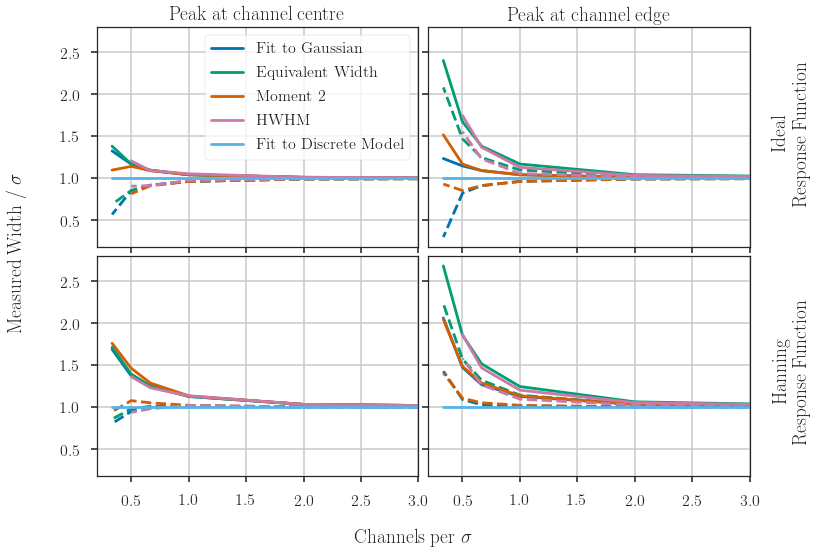

In [72]:
cpal = sb.color_palette()

fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)

# First panel is channel centered w/ finite sampling

# axs[0, 0].axvline(1., color=cpal[0])
axs[0, 0].plot(sigma / chan_widths, stddev_weight / sigma, color=cpal[0],
               label='Fit to Gaussian')
axs[0, 0].plot(sigma / chan_widths, stddev_weight_deconv / sigma, '--', color=cpal[0])
axs[0, 0].plot(sigma / chan_widths, stddev_weight_equiv / sigma, color=cpal[1],
               label='Equivalent Width')
axs[0, 0].plot(sigma / chan_widths, stddev_weight_equiv_deconv / sigma, '--',
               color=cpal[1])
axs[0, 0].plot(sigma / chan_widths, stddev_weight_mom2 / sigma, color=cpal[2],
               label='Moment 2')
axs[0, 0].plot(sigma / chan_widths, stddev_weight_mom2_deconv / sigma, '--',
               color=cpal[2])
axs[0, 0].plot(sigma / chan_widths, stddev_weight_hwhm / sigma, color=cpal[3],
               label='HWHM')
axs[0, 0].plot(sigma / chan_widths, stddev_weight_hwhm_deconv / sigma, '--',
               color=cpal[3])
axs[0, 0].plot(sigma / chan_widths, stddev_weight_formod / sigma, color=cpal[5],
               label='Fit to Discrete Model')
axs[0, 0].legend(frameon=True, fontsize=16)
axs[0, 0].grid()
axs[0, 0].set_title("Peak at channel centre")
# axs[0, 0].text(0.5, 2.5, "Peak at channel centre",
#               bbox={"boxstyle": "square", "facecolor": "w"})

# First column, second row is the convolved model
axs[1, 0].plot(sigma / chan_widths, stddev_weight_resp / sigma, color=cpal[0],
               label='Fit to Gaussian')
axs[1, 0].plot(sigma / chan_widths, stddev_weight_resp_deconv / sigma, '--', color=cpal[0])
axs[1, 0].plot(sigma / chan_widths, stddev_weight_resp_equiv / sigma, color=cpal[1],
               label='Equivalent Width')
axs[1, 0].plot(sigma / chan_widths, stddev_weight_resp_equiv_deconv / sigma, '--',
               color=cpal[1])
axs[1, 0].plot(sigma / chan_widths, stddev_weight_resp_mom2 / sigma, color=cpal[2],
               label='Moment 2')
axs[1, 0].plot(sigma / chan_widths, stddev_weight_resp_mom2_deconv / sigma, '--',
               color=cpal[2])
axs[1, 0].plot(sigma / chan_widths, stddev_weight_resp_hwhm / sigma, color=cpal[3],
               label='HWHM')
axs[1, 0].plot(sigma / chan_widths, stddev_weight_resp_hwhm_deconv / sigma, '--',
               color=cpal[3])
axs[1, 0].plot(sigma / chan_widths, stddev_weight_resp_formod / sigma, color=cpal[5],
               label='Fit to Discrete Model')
axs[1, 0].grid()

# Second row are with half a channel offset
axs[0, 1].plot(sigma / chan_widths, stddev_weight_offset / sigma, color=cpal[0],
               label='Fit to Gaussian')
axs[0, 1].plot(sigma / chan_widths, stddev_weight_deconv_offset / sigma, '--', color=cpal[0])
axs[0, 1].plot(sigma / chan_widths, stddev_weight_equiv_offset / sigma, color=cpal[1],
               label='Equivalent Width')
axs[0, 1].plot(sigma / chan_widths, stddev_weight_equiv_deconv_offset / sigma, '--',
               color=cpal[1])
axs[0, 1].plot(sigma / chan_widths, stddev_weight_mom2_offset / sigma, color=cpal[2],
               label='Moment 2')
axs[0, 1].plot(sigma / chan_widths, stddev_weight_mom2_deconv_offset / sigma, '--',
               color=cpal[2])
axs[0, 1].plot(sigma / chan_widths, stddev_weight_hwhm_offset / sigma, color=cpal[3],
               label='HWHM')
axs[0, 1].plot(sigma / chan_widths, stddev_weight_hwhm_deconv_offset / sigma, '--',
               color=cpal[3])
axs[0, 1].plot(sigma / chan_widths, stddev_weight_formod_offset / sigma, color=cpal[5],
               label='Fit to Discrete Model')
axs[0, 1].grid()
axs[0, 1].set_title("Peak at channel edge")

# First column, second row is the convolved model
axs[1, 1].plot(sigma / chan_widths, stddev_weight_resp_offset / sigma, color=cpal[0],
               label='Fit to Gaussian')
axs[1, 1].plot(sigma / chan_widths, stddev_weight_resp_deconv_offset / sigma, '--', color=cpal[0])
axs[1, 1].plot(sigma / chan_widths, stddev_weight_resp_equiv_offset / sigma, color=cpal[1],
               label='Equivalent Width')
axs[1, 1].plot(sigma / chan_widths, stddev_weight_resp_equiv_deconv_offset / sigma, '--',
               color=cpal[1])
axs[1, 1].plot(sigma / chan_widths, stddev_weight_resp_mom2_offset / sigma, color=cpal[2],
               label='Moment 2')
axs[1, 1].plot(sigma / chan_widths, stddev_weight_resp_mom2_deconv_offset / sigma, '--',
               color=cpal[2])
axs[1, 1].plot(sigma / chan_widths, stddev_weight_resp_hwhm_offset / sigma, color=cpal[3],
               label='HWHM')
axs[1, 1].plot(sigma / chan_widths, stddev_weight_resp_hwhm_deconv_offset / sigma, '--',
               color=cpal[3])
axs[1, 1].plot(sigma / chan_widths, stddev_weight_resp_formod_offset / sigma, color=cpal[5],
               label='Fit to Discrete Model')
axs[1, 1].grid()

axs[1, 1].set_xlim([0.2, 3])
# axs[1, 1].set_ylim([8, 15])
# axs[1].set_xlabel(r"Channels per $\sigma$")

fig.text(0.5, 0.02, r'Channels per $\sigma$', ha='center', va='center')
fig.text(0.03, 0.5, r'Measured Width / $\sigma$',
         ha='center', va='center', rotation='vertical')

fig.text(0.95, 0.7, 'Ideal\nResponse Function', ha='center',
         va='center', rotation='vertical')
fig.text(0.95, 0.3, 'Hanning\nResponse Function', ha='center',
         va='center', rotation='vertical')

fig.subplots_adjust(hspace=0.04, wspace=0.03)

fig.savefig("width_recovery_comparison.pdf")

The four panels show the recovered line widths for the different methods when the peak is located at the centre (left column) or edge (right column) and with no spectral response function (top row) and the Hanning response function (bottom row). Solid lines indicate widths from the methods, and dashed lines are the widths deconvolved from the correction factor.

For an ideal response function with the peak at the centre of the channel, the correction factor over-corrects for line broadening for all methods.  If the peak is located at the channel edge, the equivalent width and HWHM line widths are much larger, and the correction factor under-corrects for the broadening. In no case does the deconvolved widths equal the correct line width. The only method that correctly recover the line width is the forward-modeling (light blue line).

For the models convolved with a response function, the behaviours of the line width are qualitatively the same as those with the ideal response function, though the widths are larger in this case. The empirically-derived correction factor from Leroy et al. (2016) tends to correctly recover the true line width to within a few percent wehn the peak is located at the channel centre. When the peak is at the channel edge, the correction factor only works well for the direct Gaussian fit (without forward modelling) and the second moment. Forward-modelling with the finite channels and the spectral response function is again the only method that correctly recovers the line width in all cases.

These examples are all noiseless. If the spectrum has been convolved with a spectral response function, the noise will not be independent between the channels. However, the fitting used above assumes that the uncertainty in each channel is independent of the other channels. We will now test whether breaking this assumption leads to biased estimates

In [25]:
amps = []
stddevs = []
means = []

p_amp = 0.
p_std = 0.
p_mean = 0.

sigma_noise = 0.2

sigma_noises = sigma_noise * np.ones_like(vels_10)

for _ in range(1000):

    test_data = gauss_model_chanweight(vels_10) + np.random.normal(0, sigma_noise, vels_10.shape)

    # Now convolve with response function
    test_conv_data = convolve_fft(test_data, m33_kernel)
    
    test_fit = fit_convolve_model(vels_10, test_conv_data,
                                  m33_kernel, sigma=sigma_noises)
    amps.append(test_fit[0][0])
    stddevs.append(test_fit[0][1]) 
    means.append(test_fit[0][2])
    
    std_errs = np.sqrt(np.diag(test_fit[1]))
    
    # How many times is the true value within the 1-sigma errors?
    if np.abs(test_fit[0][0] - 1.) <= std_errs[0]:
        p_amp += 1.
    if np.abs(test_fit[0][1] - 10.) <= std_errs[1]:
        p_std += 1.
    if np.abs(test_fit[0][2] - 0.) <= std_errs[2]:
        p_mean += 1.
        
print(p_amp / 1000., p_std / 1000., p_mean / 1000.)

/home/eric/anaconda3/lib/python3.6/site-packages/astropy/convolution/convolve.py:672: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bigarray[arrayslices] = array
/home/eric/anaconda3/lib/python3.6/site-packages/astropy/convolution/convolve.py:678: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bigkernel[kernslices] = normalized_kernel
/home/eric/anaconda3/lib/python3.6/site-packages/astropy/convolution/convolve.py:694: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `a

0.744 0.704 0.692


A two-tailed p-test at the $1\sigma$ level should give $0.682$. All of these are larger than that value, which means that the standard errors are underestimated. The correlated errors can be accounted for in the model with a Gaussian process, but we will not investigate that here.

Are the derived parameters biased?

(0, 30)

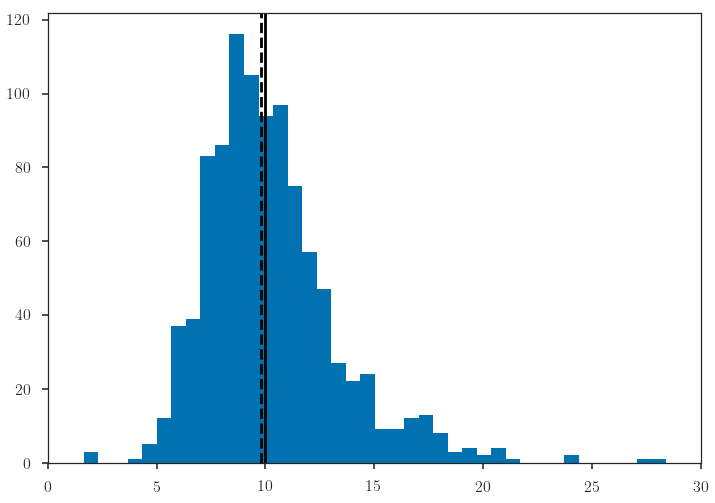

In [26]:
_ = plt.hist(stddevs, bins='auto')
plt.axvline(np.median(stddevs), color='k', linestyle='--')
plt.axvline(10., color='k', linestyle='-')
plt.xlim([0, 30])

(-10, 10)

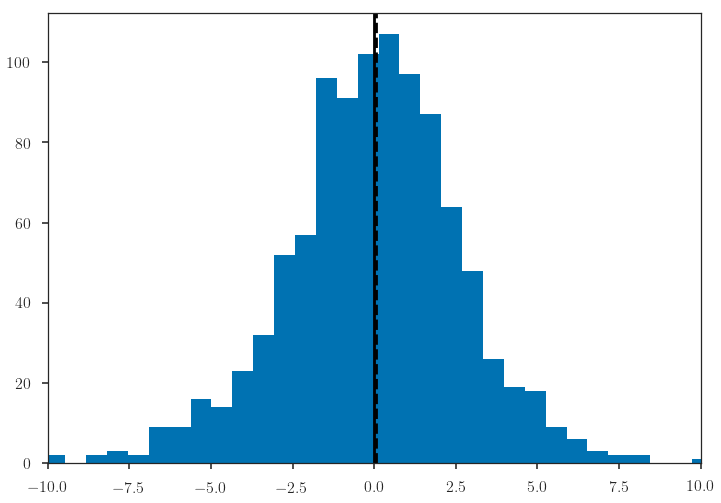

In [27]:
_ = plt.hist(means, bins='auto')
plt.axvline(np.median(means), color='k', linestyle='--')
plt.axvline(0.0, color='k', linestyle='-')
plt.xlim([-10, 10])

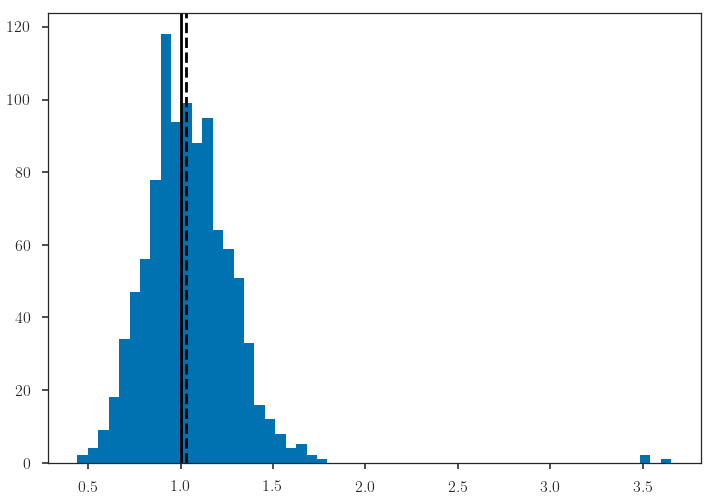

In [28]:
_ = plt.hist(amps, bins='auto')
plt.axvline(np.median(amps), color='k', linestyle='--')
plt.axvline(1., color='k', linestyle='-')

The recovered fit parameters are not biased beyond the typical standard errors.

Lastly, make the figure to go in the paper:

/home/eric/anaconda3/lib/python3.6/site-packages/astropy/convolution/convolve.py:672: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bigarray[arrayslices] = array
/home/eric/anaconda3/lib/python3.6/site-packages/astropy/convolution/convolve.py:678: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bigkernel[kernslices] = normalized_kernel
/home/eric/anaconda3/lib/python3.6/site-packages/astropy/convolution/convolve.py:694: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `a

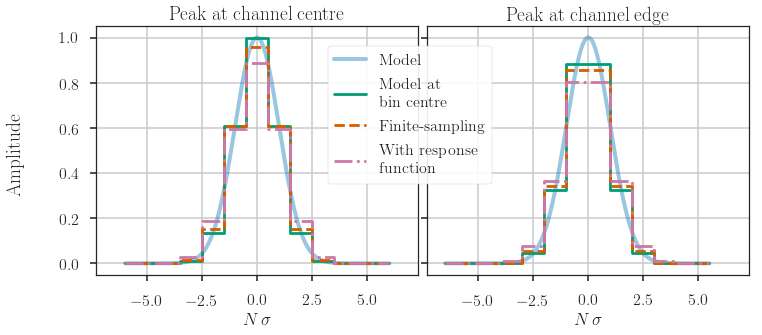

In [71]:
fig, ax = plt.subplots(1, 2, figsize=(11.7, 8.27 / 1.75), sharex=True, sharey=True)

ax[0].plot(vels_01 / sigma, gauss_model(vels_01), label='Model',
           linewidth=4, alpha=0.4)
ax[0].plot(vels_10 / sigma, gauss_model(vels_10), label='Model at \nbin centre',
           drawstyle='steps-mid')
ax[0].plot(vels_10 / sigma, gauss_model_chanweight(vels_10), '--',
           label='Finite-sampling', drawstyle='steps-mid')
ax[0].plot(vels_10 / sigma, convolve_gauss_model_chanweight(vels_10, m33_kernel),
           '-.', label='With response \nfunction', drawstyle='steps-mid')
ax[0].grid()
ax[0].set_xlim([-7.3, 7.3])
ax[0].set_title("Peak at channel centre")
# ax[0].set_ylabel("Amplitude")
ax[0].set_xlabel(r"$N \, \sigma$")

ax[1].plot((vels_01 - 5.) / sigma, gauss_model(vels_01 - 5.), label='Model',
           linewidth=4, alpha=0.4)
ax[1].plot((vels_10 - 5.) / sigma, gauss_model(vels_10 - 5.),
           label='Model at \nbin centre',
           drawstyle='steps-mid')
ax[1].plot((vels_10 - 5.) / sigma, gauss_model_chanweight(vels_10 - 5.), '--',
           label='Finite-sampling', drawstyle='steps-mid')
ax[1].plot((vels_10 - 5.) / sigma,
           convolve_gauss_model_chanweight(vels_10 - 5., m33_kernel),
           '-.', label='With response \nfunction', drawstyle='steps-mid')
# ax[1].legend(frameon=True, loc='upper right')
ax[1].grid()
ax[1].set_title("Peak at channel edge")
# plt.ylabel("Amplitude")
ax[1].set_xlabel(r"$N \, \sigma$")

# plt.tight_layout()

handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.43, 0.45), frameon=True, framealpha=0.9)

# fig.text(0.5, 0.03, r'$N \, \sigma$', ha='center', va='center')
fig.text(0.03, 0.5, r'Amplitude',
         ha='center', va='center', rotation='vertical')

fig.subplots_adjust(hspace=0.04, wspace=0.03, bottom=0.15)

fig.savefig("example_model_chan_1sigma_both.pdf")
